In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from utils import calculate_gmrotd50, SeismicParameters
import h5py
from tqdm import tqdm
from example_GMM import calculate_gmfs, parallel_processing_sa
import pyrotd
from einops import rearrange
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.stats import norm

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})

# Calculate standard deviation
def find_closest_index(x, value):
    """
    Find the index of the closest value in the array x to the given value.
    If the value is at the lowest or highest edge, return the last known index.

    Parameters:
    x (numpy.ndarray): Array of values to search.
    value (float): The value to find the closest index for.

    Returns:
    int: The index of the closest value in the array.
    """
    if value <= x[0]:
        return 0
    elif value >= x[-1]:
        return len(x) - 1
    else:
        closest_index = np.argmin(np.abs(x - value))
        return closest_index
    
def find_probability(sa_mean, sa_16, sa_84, IM, bin_plot, IM_distance):
    median = np.log(sa_mean)
    IM = np.log(IM)
    
    percentile_16 = np.log(sa_16)
    percentile_84 = np.log(sa_84)
    sigma = (percentile_84 - percentile_16) / 2
    
    # Standardize the value
    z = (IM - median) / sigma
    
    # Calculate the probability
    probability = norm.pdf(IM, median, sigma)
    
    return probability

def find_probability_obs(sa_mean, sa_16, sa_84, IM, bin_plot, IM_distance):
    ids = find_closest_index(bin_plot, IM_distance)
    median = np.log(sa_mean[ids])
    IM = np.log(IM)
    
    percentile_16 = np.log(sa_16[ids])
    percentile_84 = np.log(sa_84[ids])
    sigma = (percentile_84 - percentile_16) / 2
    
    # Standardize the value
    z = (IM - median) / sigma
    
    # Calculate the probability
    probability = norm.pdf(IM, median, sigma)
    
    return probability


In [2]:
distance = np.linspace(1, 190, 50)
magnitude = np.linspace(4.5, 8.0, 15)
vs30 = np.linspace(100, 1500, 6)
samples = 100
print(magnitude)
for j in range(len(vs30)-1):
    print(0.5*(vs30[j]+vs30[j+1]))

[4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.   7.25 7.5  7.75
 8.  ]
240.0
520.0
800.0
1080.0
1360.0


In [3]:
# for i in range(len(vs30)-1):
#     vs30_ave = 0.5*(vs30[i]+vs30[i+1])
#     for j in range(len(magnitude)):
#         write_prob = open(f"gm0_files/ProbGM0_M{magnitude[j]}_vs30_{vs30_ave}.csv","wt")
#         write_prob.write("hypocentral_distance,hypocentre_depth,magnitude,vs30,azimuthal_gap,num_samples\n")
#         for k in range(len(distance)):
#             write_prob.write(f"{distance[k]},20,{magnitude[j]},{vs30_ave},130,{samples}\n")
#         write_prob.close()


In [45]:
import glob

datasets = glob.glob('../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M*_240.0.h5')
datasets = np.sort(datasets)
print(datasets)
print(magnitude)

['../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M4.5_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M4.75_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.0_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.25_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.5_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.75_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.0_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.25_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.5_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.75_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.0_vs30_240.0.h5'
 '../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.25_vs30_240.0.h5'
 '../experiments/workd

In [46]:
sa_mean_01 = []
for dataset_generated in datasets:
    files = SeismicParameters(dataset_generated)
    print(dataset_generated)

    distance_generate = files.hypocentral_distance
    mag_generate = files.magnitude
    st_tqdne = files.waveforms

    st_tqdne_EW = st_tqdne[:, 1, :]
    st_tqdne_NS = st_tqdne[:, 0, :]

    angles = np.arange(0, 180, step=1)
    dt = 0.01
    periods = np.array([0.1, 0.3, 1, 2])
    percentile = 50

    sa_mean_01_file = parallel_processing_sa(st_tqdne_NS, st_tqdne_EW, dt, periods, percentile)
    
    sa_mean_01.append(sa_mean_01_file)

sa_mean_01 = np.array(sa_mean_01)
    

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M4.5_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6958035.83it/s]

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M4.75_vs30_240.0.h5


0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7013886.29it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.0_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7027989.28it/s]

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.25_vs30_240.0.h5


0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7101767.69it/s]

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.5_vs30_240.0.h5


0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6971914.89it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M5.75_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7025634.84it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.0_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6995170.11it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.25_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7037422.82it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.5_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6976553.56it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M6.75_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6914447.74it/s]

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.0_vs30_240.0.h5


0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6797899.51it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.25_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6958035.83it/s]

../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.5_vs30_240.0.h5


0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 7089763.35it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M7.75_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6914447.74it/s]


../experiments/workdir/new_highfem1/h5_probability/ProbGM0_M8.0_vs30_240.0.h5
0
1000
2000
3000
4000


100%|██████████| 5000/5000 [00:00<00:00, 6974233.46it/s]


In [47]:
files = SeismicParameters('../experiments/workdir/new_highfem1/test_data.h5')
# Load data
files.waveforms = rearrange(files.waveforms, "b t c -> b c t")
files.waveforms = files.waveforms[:,:,:4064]

vs30_data = files.vs30s
distance_data_1 = files.hypocentral_distance
j = 0
idx_vs30 = (vs30_data >= vs30[j]) & (vs30_data < vs30[j+1]) #(vs30_data >= vs30[j]) & (vs30_data < vs30[j+1])
idx_vs30 = idx_vs30 
distance_data = files.hypocentral_distance[idx_vs30]
mag_data = files.magnitude[idx_vs30]
target_waveform = files.waveforms[idx_vs30,:,:]



In [48]:
vs30[j], vs30[j+1]

(100.0, 380.0)

In [49]:
bin_plot = np.linspace(1, 190, 50)
bin_mag = np.linspace(4.5, 8.0, 15)
PSA_mean_obs = np.zeros((len(bin_mag), len(bin_plot)))
PSA_16_obs = np.zeros((len(bin_mag), len(bin_plot)))
PSA_84_obs = np.zeros((len(bin_mag), len(bin_plot)))

angles = np.arange(0, 180, step=1)
dt = 0.01
periods = np.array([0.1, 0.3, 1, 2])
percentile = 50
chunk = 500
num = int(len(target_waveform)/chunk) + 1
sa_mean_obs_file = []
for i in range(num):
    print(i, '/', int(len(target_waveform)/chunk))
    wf_EW = target_waveform[i*chunk:i*chunk+chunk, 1, :]
    wf_NS = target_waveform[i*chunk:i*chunk+chunk, 0, :]

    sa_mean_obs_file.append(parallel_processing_sa(wf_NS, wf_EW, dt, periods, percentile))

if num == 1:
    sa_mean_obs = np.array(sa_mean_obs_file[0])
    sa_mean_obs_concatenate = sa_mean_obs.reshape(1*sa_mean_obs.shape[0], sa_mean_obs.shape[1])
else:
    sa_mean_obs = np.array(sa_mean_obs_file[0:num-1])
    sa_mean_obs_concatenate = sa_mean_obs.reshape(sa_mean_obs.shape[0]*sa_mean_obs.shape[1], sa_mean_obs.shape[2])
    sa_mean_obs_concatenate = np.vstack((sa_mean_obs_concatenate, np.array(sa_mean_obs_file[num-1])))


0 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4161015.87it/s]

1 / 29


0


100%|██████████| 500/500 [00:00<00:00, 3826919.71it/s]

2 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4228129.03it/s]

3 / 29


0


100%|██████████| 500/500 [00:00<00:00, 3883614.81it/s]

4 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4452552.02it/s]

5 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4378187.89it/s]

6 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4211148.59it/s]

7 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4619277.53it/s]

8 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4452552.02it/s]

9 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4245246.96it/s]

10 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4529485.96it/s]

11 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4396545.07it/s]

12 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4702134.53it/s]

13 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4415056.84it/s]

14 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4462025.53it/s]

15 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4519724.14it/s]

16 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4619277.53it/s]

17 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4500326.18it/s]

18 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4539290.04it/s]

19 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4297442.62it/s]

20 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4471539.45it/s]

21 / 29


0


100%|██████████| 500/500 [00:00<00:00, 3765084.38it/s]

22 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4588954.05it/s]

23 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4510004.30it/s]

24 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4539290.04it/s]

25 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4017532.57it/s]

26 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4471539.45it/s]

27 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4415056.84it/s]

28 / 29


0


100%|██████████| 500/500 [00:00<00:00, 4245246.96it/s]

29 / 29


0


100%|██████████| 3/3 [00:00<00:00, 57456.22it/s]


In [62]:
period = 3
dist_filt = np.zeros((len(bin_mag), len(bin_plot)))
sa_mean = np.zeros((len(bin_mag), len(bin_plot)))
sa_16 = np.zeros((len(bin_mag), len(bin_plot)))
sa_84 = np.zeros((len(bin_mag), len(bin_plot)))

for ii in range(len(bin_mag)):
    for i in range(len(bin_plot)):
        # mask1 = (distance_generate >= bin_plot[i]) & (distance_generate <= bin_plot[i+1])
        # mask11 = (magnitude_generate >= bin_mag[ii]) & (magnitude_generate < bin_mag[ii+1])
        mask = np.round(distance_generate, decimals=8) == np.round(bin_plot[i], decimals=8)
        
        # mask2 = distance == bin_plot[i]
        sa_mean[ii, i] = (np.percentile(sa_mean_01[ii, mask, period], 50))
        sa_16[ii, i] = (np.percentile(sa_mean_01[ii, mask, period], 16))
        sa_84[ii, i] = (np.percentile(sa_mean_01[ii, mask, period], 84))

In [63]:
probability = np.zeros((len(bin_mag)-1, len(bin_plot)-1))
probability[:] = np.nan
for ii in range(len(bin_mag)-2):
    for i in range(len(bin_plot)-1):
        mask1 = (distance_data >= bin_plot[i]) & (distance_data < bin_plot[i+1])
        mask11 = (mag_data >= bin_mag[ii]) & (mag_data < bin_mag[ii+1])
        mask = mask1 & mask11
        
        mask2 = np.round(distance_generate, decimals=8) == np.round(bin_plot[i], decimals=8)
        
        sa_mean = (np.percentile(sa_mean_01[ii, mask2, period], 50))
        sa_16 = (np.percentile(sa_mean_01[ii, mask2, period], 16))
        sa_84 = (np.percentile(sa_mean_01[ii, mask2, period], 84))
        
        sa_mean_obs = sa_mean_obs_concatenate[mask, period]
        distance_data_eval = distance_data[mask]
        temp_prob = 0
        for kk in range(len(distance_data_eval)):
            ids = find_closest_index(bin_plot, distance_data_eval[kk])
            probs = find_probability(sa_mean, sa_16, sa_84, sa_mean_obs[kk], bin_plot, distance_data_eval[kk])
            temp_prob += probs
        if len(distance_data_eval) == 0:
            probability[ii, i] = np.nan
        else:
            probability[ii, i] = temp_prob/len(distance_data_eval)

In [64]:
rupture_aratio = 1.5
strike = 45
dip = 50
rake = 0
lon = 9.1500
lat = 45.1833
depth = 15
Vs30 = float(dataset_generated.split('_')[-1].split('.')[0])
hypocenter = [lon, lat, depth]
imts = [f'SA({periods[period]})']
gmpes = ['BooreEtAl2014', 'Kanno2006Shallow']
imt = 1

probability_GMM = np.zeros((len(bin_mag)-1, len(bin_plot)-1))
probability_GMM[:] = np.nan
for ii in range(len(bin_mag)-2):
    for i in range(len(bin_plot)-1):
        mask1 = (distance_data >= bin_plot[i]) & (distance_data < bin_plot[i+1])
        mask11 = (mag_data >= bin_mag[ii]) & (mag_data < bin_mag[ii+1])
        mask = mask1 & mask11
        
        gms, jb_distances = calculate_gmfs(0.5*(bin_mag[ii]+bin_mag[ii+1]), rupture_aratio, strike, dip, rake, hypocenter, imts, Vs30, gmpes)
        idx = (jb_distances >= bin_plot[i]) & (jb_distances < bin_plot[i+1])
        jb_distances = jb_distances[idx]
        
        sa_mean = np.exp(gms[0, imt, 0][idx]) *9.81
        sa_16 = np.exp(gms[0, imt, 0][idx] - gms[1, imt, 0][idx]) *9.81
        sa_84 = np.exp(gms[0, imt, 0][idx] + gms[1, imt, 0][idx]) *9.81
        
        sa_mean_obs = sa_mean_obs_concatenate[mask, period]
        distance_data_eval = distance_data[mask]
        temp_prob = 0
        for kk in range(len(distance_data_eval)):
            ids = find_closest_index(bin_plot, distance_data_eval[kk])
            probs = find_probability_obs(sa_mean, sa_16, sa_84, sa_mean_obs[kk], jb_distances, distance_data_eval[kk])
            temp_prob += probs
        if len(distance_data_eval) == 0:
            probability_GMM[ii, i] = np.nan
        else:
            probability_GMM[ii, i] = temp_prob /len(distance_data_eval)

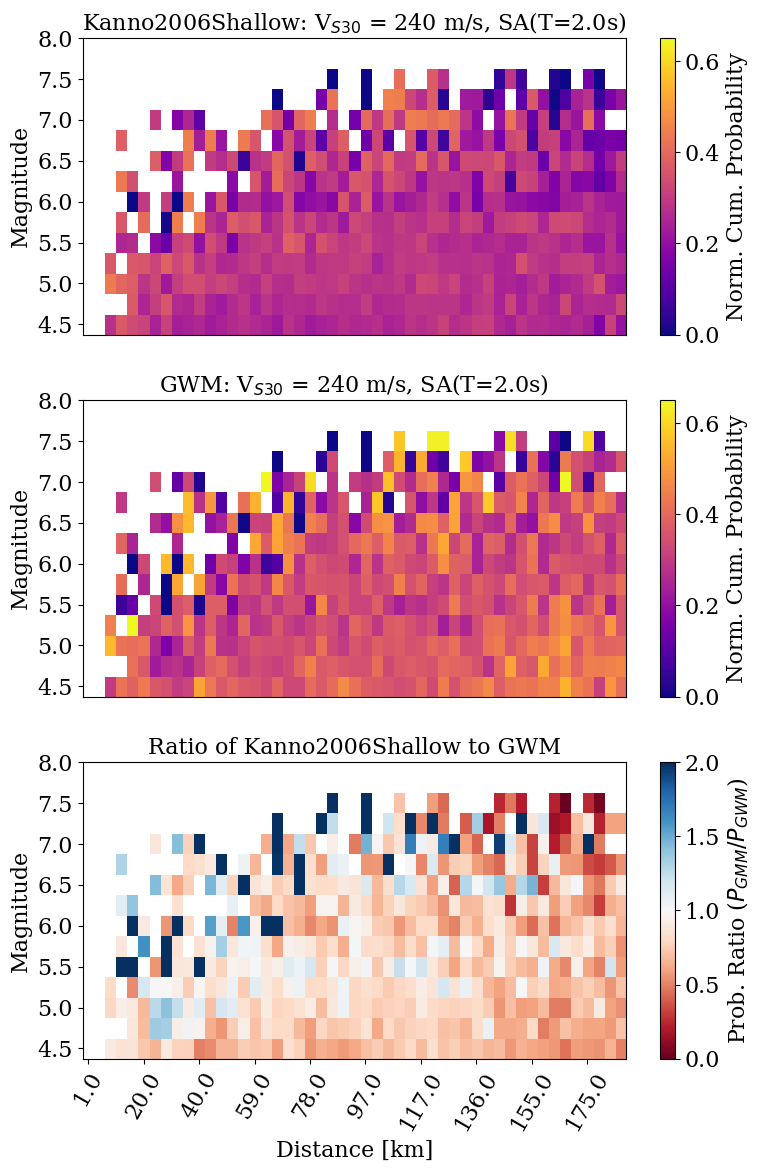

In [65]:
# Calculate the ratio
ratio = probability_GMM / probability

# Determine vmax from the maximum value of probability_GMM and probability
arr = np.concatenate((probability_GMM, probability))
mask = (~np.isnan(arr)) & (arr != 0)
arr_filtered = arr[mask]
vmax_value = (np.max(arr_filtered))
vmin_value = (np.min(arr_filtered))

# Set up the figure with custom size
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Plot the probability_GMM data
cax1 = axes[0].imshow((probability_GMM), origin='lower', cmap='plasma', aspect='auto', vmin=0, vmax=0.65)
cbar1 = fig.colorbar(cax1, ax=axes[0], label="Norm. Cum. Probability")
axes[0].set_ylabel('Magnitude')
axes[0].set_title(f"{gmpes[imt]}: V$_{{S30}}$ = {dataset_generated.split('_')[-1].split('.')[0]} m/s, SA(T={periods[period]}s)", fontsize=16)
xtick = np.arange(0, len(bin_mag), 2)
ytick = np.arange(0, len(bin_plot), 5)
axes[0].set_yticks(xtick)
axes[0].set_yticklabels(['4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0'])
ylabel = [str(np.round(bin_plot[i], decimals=0)) for i in ytick]
axes[0].set_xticks([])
axes[0].set_xticklabels([])

# Plot the probability data
cax2 = axes[1].imshow((probability), origin='lower', cmap='plasma', aspect='auto', vmin=0, vmax=0.65)
cbar2 = fig.colorbar(cax2, ax=axes[1], label="Norm. Cum. Probability")
axes[1].set_ylabel('Magnitude')
axes[1].set_title(f"GWM: V$_{{S30}}$ = {dataset_generated.split('_')[-1].split('.')[0]} m/s, SA(T={periods[period]}s)", fontsize=16)
axes[1].set_yticks(xtick)
axes[1].set_yticklabels(['4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0'])
axes[1].set_xticks([])
axes[1].set_xticklabels([])

# Plot the ratio data
cax3 = axes[2].imshow(ratio, origin='lower', cmap='RdBu', aspect='auto', vmin=0, vmax=2)
cbar3 = fig.colorbar(cax3, ax=axes[2], label="Prob. Ratio ($P_{GMM}/P_{GWM}$)")
axes[2].set_ylabel('Magnitude')
axes[2].set_xlabel('Distance [km]')
axes[2].set_title(f"Ratio of {gmpes[imt]} to GWM", fontsize=16)
axes[2].set_yticks(xtick)
axes[2].set_yticklabels(['4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0'])
axes[2].set_xticks(ytick)
axes[2].set_xticklabels(ylabel)
plt.setp(axes[2].get_xticklabels(), rotation=60)

# Adjust layout
plt.tight_layout()
fig.savefig(f"figures/updated/probability/Probability_Vs30_{dataset_generated.split('_')[-1].split('.')[0]}_{gmpes[imt]}_SA_{periods[period]}.png", dpi=200, bbox_inches='tight')
plt.show()